# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [3]:
### Set the folder the stores the image files
image_dir="./traffic-signs-data/"

In [4]:
# Load pickled data
import pickle
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
import os
# TODO: Fill this in based on where you saved the training and testing data

training_file = os.path.join(image_dir,"train.p")

testing_file = os.path.join(image_dir,"test.p")

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
raw_X_train, raw_y_train = train['features'], train['labels']
raw_X_test, raw_y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [5]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = train["labels"].shape[0]

# TODO: Number of testing examples.
n_test = test["labels"].shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = train["features"][0].shape

# TODO: How many unique classes/labels there are in the dataset.
all_labels,all_labels_index=np.unique(train['labels'],return_index=True)
n_classes = all_labels.shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [6]:
# Load signnames.csv
import pandas as pd
signnames_df=pd.DataFrame.from_csv("signnames.csv")

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [7]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

### Visualize sample images of each label

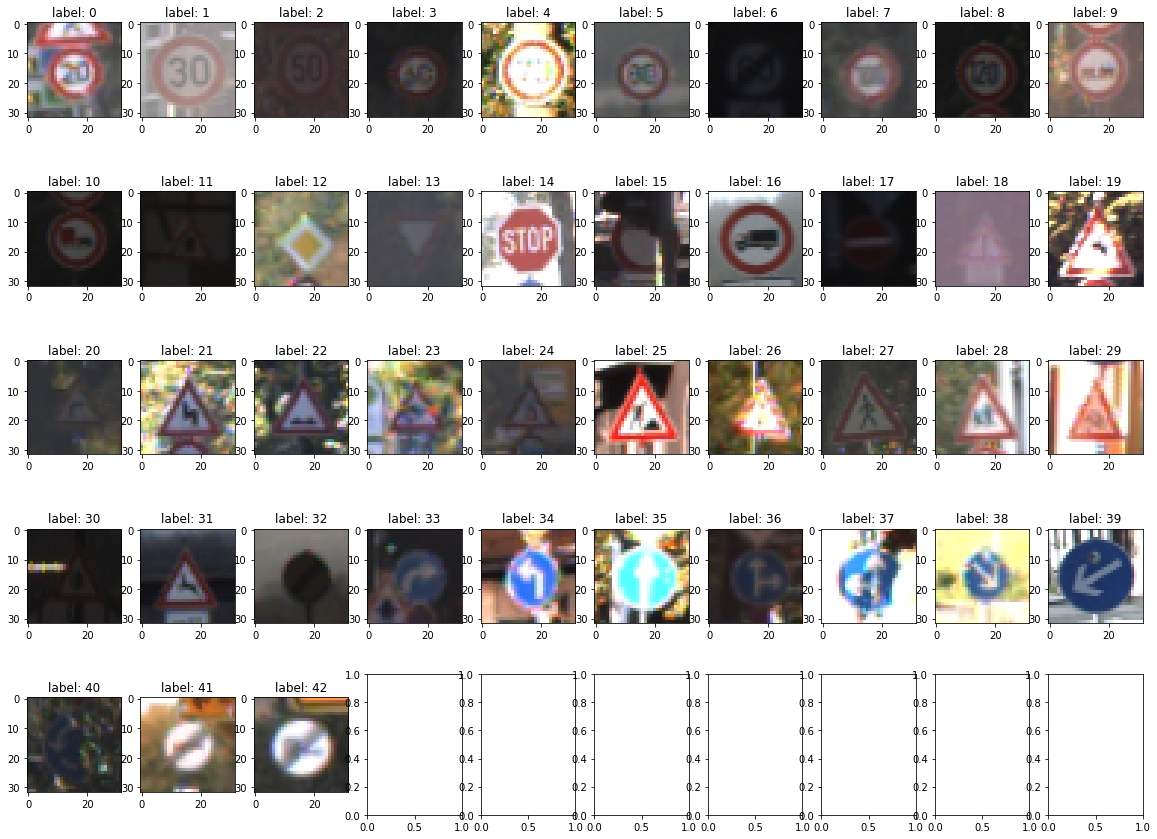

In [8]:
f,ax=plt.subplots(5,10,figsize=(20,15))
for i in range(n_classes):
    subplot_x=i//10
    subplot_y=i%10
    ax[subplot_x,subplot_y].imshow(raw_X_train[all_labels_index[i]])
    ax[subplot_x,subplot_y].set_title("label: %s"%all_labels[i])

### Visualize the distribution of the labels in train and test data

In [58]:
train_unique_values,train_unique_counts=np.unique(train["labels"],return_counts=True)
test_unique_values,test_unique_counts=np.unique(test["labels"],return_counts=True)

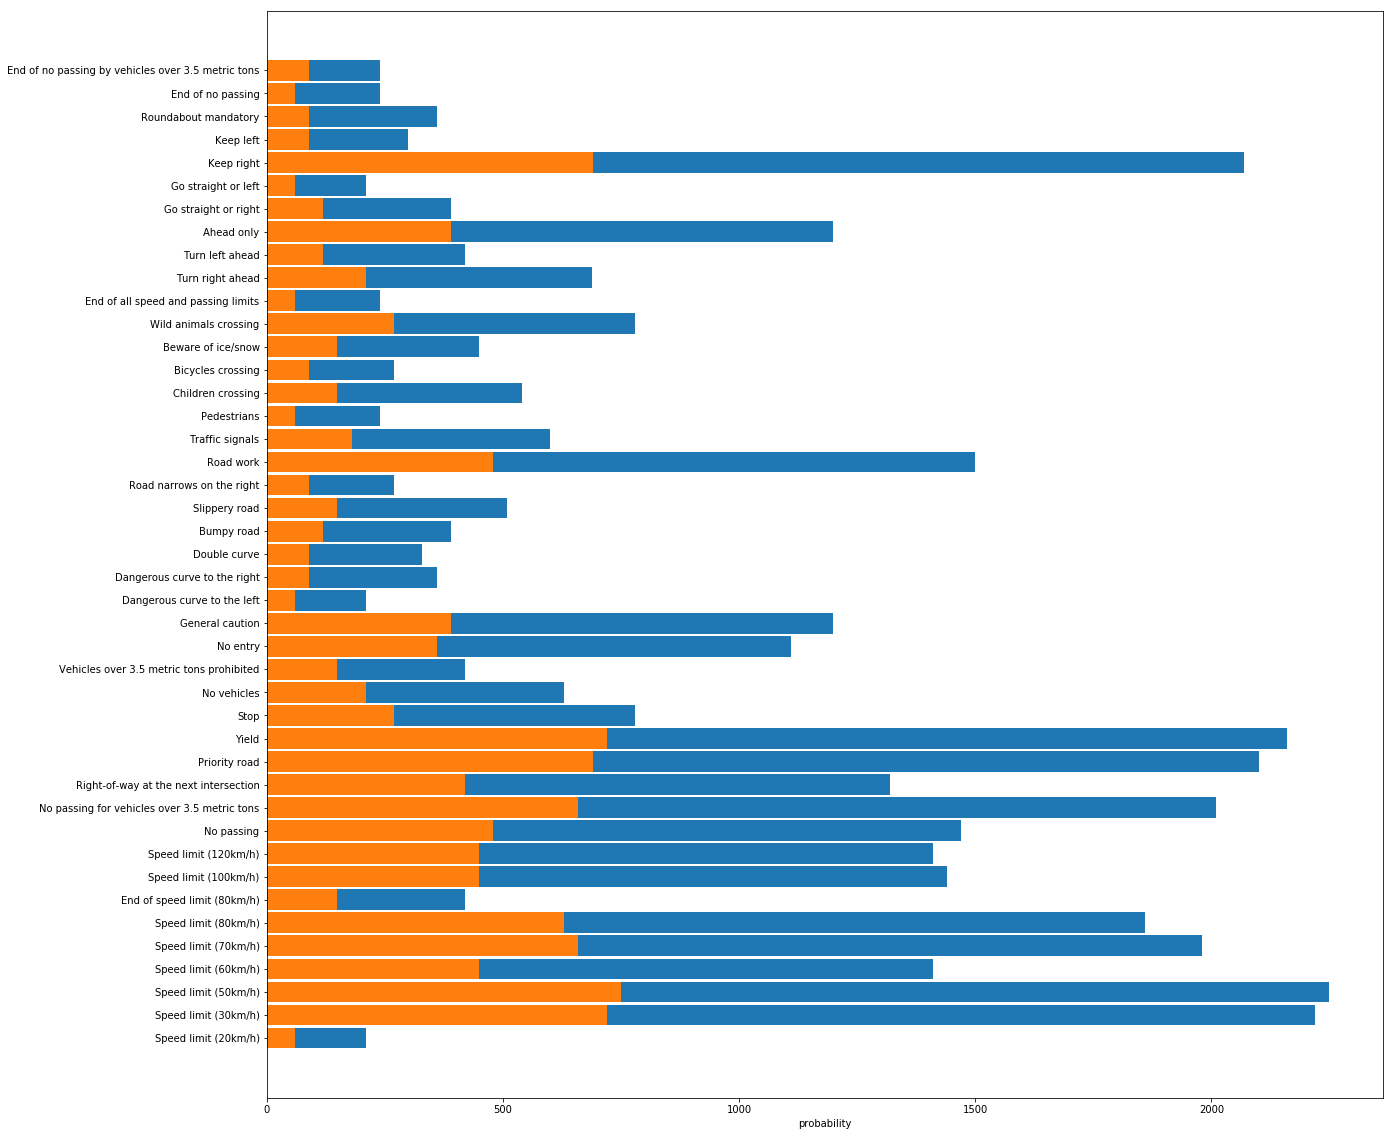

In [59]:
f,ax=plt.subplots(1,figsize=(20,20))
width=3
ind=np.arange(len(train_unique_counts))
ax.barh(width+ind,
        train_unique_counts,width*0.3,align='center',label='train labels')
ax.barh(width+ind,
        test_unique_counts[train_unique_values],width*0.3,align='center',label='test labels')
ax.set_yticks(ind + width)
ax.set_yticklabels(signnames_df.iloc[train_unique_values,0].values)
ax.set_xlabel('probability')

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [11]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

### Convert the image from RGB space to YUV space
Note: the steps of preprocessing are wrapped into classes in order to be compatible with ```Pipeline``` in Sci-kit learn.

In [12]:
import cv2
class YUVConverter(object):
    
    def __init__(self,keep_channel=0):
        self.keep_channel=keep_channel
        
    def transform(self,X,y=None,**fit_params):
        new_data=np.zeros_like(X)
        for i in range(X.shape[0]):
            new_data[i,:,:,:]=cv2.cvtColor(X[i,:,:,:], cv2.COLOR_BGR2YUV)
        
        
        new_data=new_data[:,:,:,self.keep_channel]
        return new_data
    
    def fit(self,X,y):
    
        return self

### Normalize the image

In [13]:
class SubMean(object):
    
    def transform(self,X,y=None,**fit_params):
        
        mean_X=np.mean(X,axis=(1,2),keepdims=True)
        return X-mean_X
    
    def fit(self,X,y,**fit_params):
        return self 
    
class Standarizer(object):
    
    def transform(self,X,y=None,**fit_params):
        
        mean_X=np.mean(X,axis=(1,2),keepdims=True)
        std_X=np.std(X,axis=(1,2),keepdims=True)
        return (X-mean_X)/std_X
        
    
    def fit(self,X,y,**fit_params):
        return self
    

### Adjust the constrast

In [14]:
class CLAHE(object):
    
    def transform(self,X,y=None,**fit_params):
        
        nX=np.zeros_like(X)
        clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(4,4))
        for idx in range(X.shape[0]):
            nX[idx,:,:,0] = clahe.apply(X[idx,:,:,:])
            
        return nX
         
    def fit(self,X,y,**fit_params):
        return self

In [15]:
def select_label(X,y,index_list):
    """
    Select the dataset with designated labels
    """
    idx=np.in1d(y,index_list)
    new_X=X[idx]
    new_y=y[idx]
    
    return new_X,new_y

Setup different preprocessing steps here

In [16]:
# Pipeline 1: convert the image to YUV space, keep all the channels, run normalization
p1=Pipeline(steps=[('yuv',YUVConverter(keep_channel=[0,1,2])),('sm',Standarizer())])
# Pipeline 2: convert the image to YUV space, keep Y channel only,run normalization 
p2=Pipeline(steps=[('yuv',YUVConverter(keep_channel=[0])),('sm',Standarizer())])
# Pipelin3 3: Keep the image in RGB space, do normalization.
p3=Pipeline(steps=[('stdscaler',Standarizer())])
p4=Pipeline(steps=[('yuv',YUVConverter(keep_channel=[0])),('clahe',CLAHE()),('sm',Standarizer())])

Select the preprocessing steps to use

In [17]:
selected_pipeline=p4
m_X_train=selected_pipeline.fit_transform(raw_X_train,raw_y_train)
m_X_test=selected_pipeline.fit_transform(raw_X_test,raw_y_test)

Show images after preprocessing

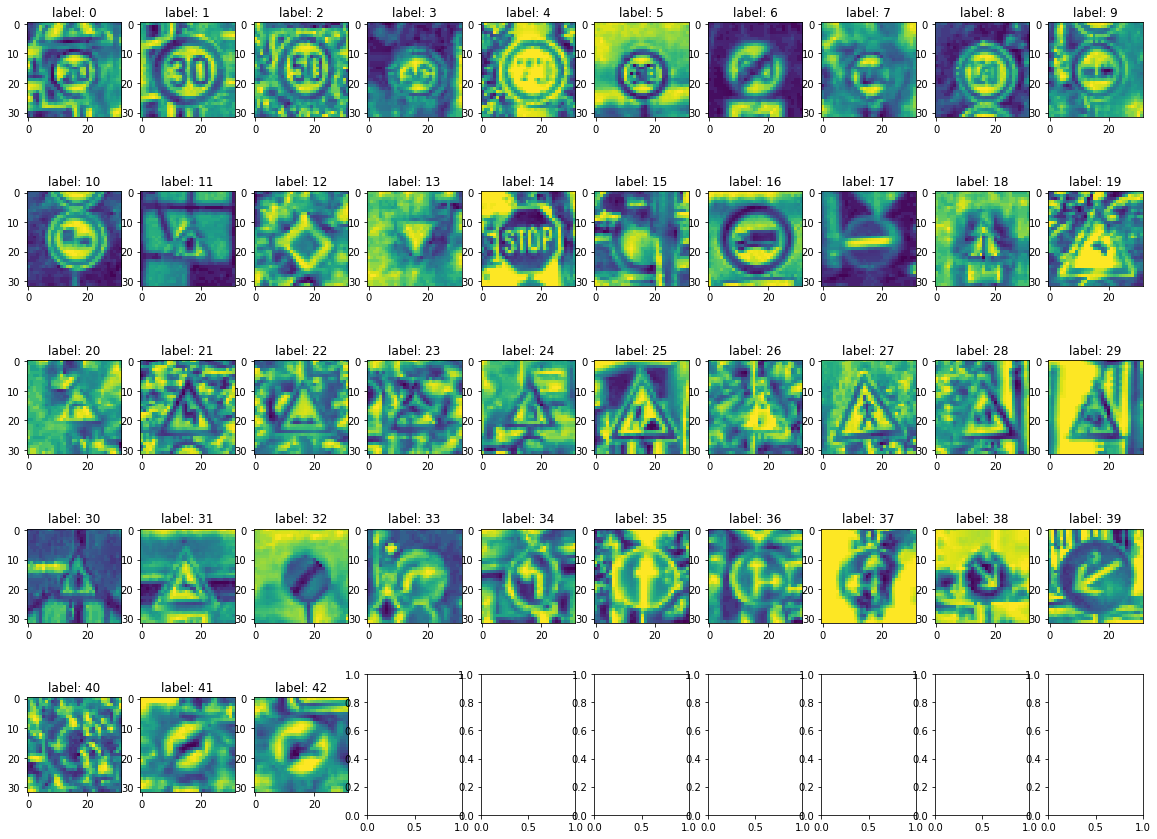

In [18]:
f,ax=plt.subplots(5,10,figsize=(20,15))
for i in range(n_classes):
    subplot_x=i//10
    subplot_y=i%10
    ax[subplot_x,subplot_y].imshow(m_X_train[all_labels_index[i],:,:,0],)
    ax[subplot_x,subplot_y].set_title("label: %s"%all_labels[i])

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

I tried four different proprocessing. Each of these preprocessing were wrapped into a Sci-kit learn ```Pipeline``` object.

1. Converting the images from RGB to YUV space and then normalizing the image. 
2. Converting the images from RGB to YUV space, keeping Y channel only, and then normalizing the image. This is essentially converting the images from RGB to greyscale.
3. Converting the images from RGB to YUV space, keeping Y channel only, adjusting the contrast by contrast limited adaptive histogram equalization (CLAHE), and then normalizing the image.
4. Just normalizing the images in their original RGB space. 

Converting the images from RGB to greyscale makes sense because the these traffic signs can all be recognized in greyscale with causing any ambiguity. Converting the color images to greyscale can reduce the variance of the dataset.

Also, since the recognition of the traffic signs in an image depends on its relative values in its pixels rather than its absolute values in each pixel. Normalization can thus be applied to reduce the variance of the dataset without causing too much loss in the information for training.

Some of the raw images look very dim. We adjust their contrast by CLAHE.

Four approaches give very close results of the accuracy on the test dataset after training, within 1%. However, I found that the model training with proprocessing 3 takes much less epochs to find the minimum loss and the maximum in-sample training accuracy. I therefore choose preprocessing 3 in the final model.

In [19]:
### Generate additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

In [20]:
include_aug_img=True
if include_aug_img==True:
    aug_training_file=os.path.join(image_dir,"aug_train.p")
    if os.path.exists(aug_training_file)==False:
        raise FileNotFoundError("Please run Generate_fake_data.ipynb to generate additional images!")
    else:
        with open(aug_training_file, mode='rb') as f:
            aug_train=pickle.load(f)

In [21]:
if include_aug_img==True:
    X1=aug_train['vert_sym_features']
    y1=aug_train['vert_sym_labels']
    X2=aug_train['horiz_sym_features']
    y2=aug_train['horiz_sym_labels']
    X3=aug_train['fp_features']
    y3=aug_train['fp_labels']
    X4=aug_train['rotate_features']
    y4=aug_train['rotate_lables']
    X5=aug_train['affine_features']
    y5=aug_train['affine_labels']

    assert X1.shape[0]==y1.shape[0]
    assert X2.shape[0]==y2.shape[0]

    aug_X=np.concatenate((X1,X2,X3,X4,X5),axis=0)
    aug_y=np.concatenate((y1,y2,y3,y4,y5),axis=0)
    aug_X_train=selected_pipeline.fit_transform(aug_X,aug_y)
    print("Total numer of additional images: %s"%aug_X_train.shape[0])

    m_X_train=np.concatenate((m_X_train,aug_X_train),axis=0)
    raw_y_train=np.concatenate((raw_y_train,aug_y),axis=0)

Total numer of additional images: 181765


Show the occurances of each label with augmented data

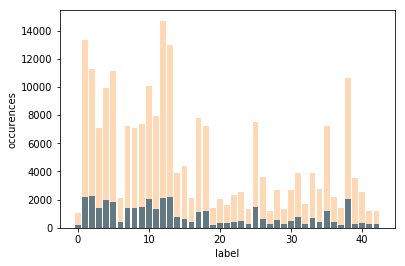

In [22]:
unique_values,unique_counts=np.unique(train["labels"],return_counts=True)
plt.bar(unique_values,unique_counts,label="original")

unique_values,unique_counts=np.unique(raw_y_train,return_counts=True)
plt.bar(unique_values,unique_counts,alpha=0.3,label="augmented")
plt.xlabel("label")
plt.ylabel("occurences")

In [23]:
# Fill-in the final X_train,y_train,X_validation, y_validation, X_test, y_test here.
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(m_X_train, 
                                                                raw_y_train, test_size=0.2, random_state=2)
X_test=m_X_test
y_test=raw_y_test

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

I randomly selected 20% of the data in ```train[features]``` as the validation set, and the rest of data in ```train['features']``` were used as the training data. All the test data (```test['features')```) are used as the test data set. 

I also generated additional dataset for train. Detailed descriptions, code and examples can be found in another file [```Generate_fake_data.ipynb```](Generate_fake_data.ipynb). In short, the additional images are generated by:

1. Exploiting the symmetry of some traffic signs.
2. Randomly roatating the images within 15 degrees.
3. Performing affine transformation of the images.

These processes generated additional 299392 images, which 7.6 times of the size of the original dataset.
The additional dataset can increase the robustness of the model after the training.

In [24]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [25]:
import tensorflow as tf
EPOCHS = 40
BATCH_SIZE = 128

In [26]:
from tensorflow.contrib.layers import flatten
def LeNet(x,dropout_keep_prob):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    l1_filter_width=5
    l1_filter_height=5
    l1_k_output=6
    color_channels=X_train.shape[-1]
    
    l1_filter=tf.Variable(tf.truncated_normal([l1_filter_width, 
                                               l1_filter_height, color_channels, l1_k_output],mean=mu,stddev=sigma))
    l1_bias=tf.Variable(tf.zeros(l1_k_output))
    
    l1_stride=1
    l1_x = tf.nn.conv2d(x, l1_filter, strides=[1, l1_stride, l1_stride, 1], padding='VALID')
    l1_x = l1_x+ l1_bias
        
    # TODO: Activation.
    l1_x=tf.nn.relu(l1_x)
    l1_x=tf.nn.local_response_normalization(l1_x)

    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    
    
    l2_x=tf.nn.max_pool(
    l1_x,
    ksize=[1, 3, 3, 1],
    strides=[1, 2, 2, 1],
    padding='VALID')

    l1_output=l2_x
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    
    l2_k_output=16
    
    l2_filter=tf.Variable(tf.truncated_normal([l1_filter_width, 
                                               l1_filter_height, l1_k_output, l2_k_output],
                         mean=mu,stddev=sigma))
    
    l2_bias=tf.Variable(tf.zeros(l2_k_output))
    l2_x = tf.nn.conv2d(l2_x, l2_filter, strides=[1, l1_stride, l1_stride, 1], padding='VALID')
    l2_x = tf.nn.bias_add(l2_x, l2_bias)

    # TODO: Activation.
    
    l2_x=tf.nn.relu(l2_x)
    l2_x=tf.nn.local_response_normalization(l2_x)
    
    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    
    l3_x=tf.nn.max_pool(l2_x,
                       ksize=[1,3,3,1],
                       strides=[1,2,2,1],
                       padding='VALID')
    
    # TODO: Flatten. Input = 5x5x16. Output = 400.
    
    l4_x=flatten(l3_x) # use "-1" to reduce the tensor to 1-d
    l1_output=flatten(l1_output)
    print(l4_x.get_shape())
    print(l1_output.get_shape())
    
    l4_x=tf.concat(concat_dim=1,values=[l4_x,l1_output])
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    
    
    features_n=256+1014
    hidden_layer_1_n=120
    
    weights_0=tf.Variable(tf.truncated_normal([features_n,hidden_layer_1_n],mean=mu,stddev=sigma))
    biases_0=tf.Variable(tf.zeros(hidden_layer_1_n))
    
    l4_x=tf.matmul(l4_x,weights_0)+biases_0
    
    # TODO: Activation.
    
    l5_x=tf.nn.relu(l4_x)
    
    l5_x=tf.nn.dropout(l5_x,keep_prob=dropout_keep_prob)

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    
    hidden_layer_2_n=84
    weights_1=tf.Variable(tf.truncated_normal([hidden_layer_1_n,hidden_layer_2_n],mean=mu,stddev=sigma))
    biases_1=tf.Variable(tf.zeros([hidden_layer_2_n]))
    l5_x=tf.add(tf.matmul(l5_x,weights_1),biases_1)
    
    # TODO: Activation.
    l6_x=tf.nn.relu(l5_x)
    l6_x=tf.nn.dropout(l6_x,keep_prob=dropout_keep_prob)

    # TODO: Layer 5: Fully Connected. Input = 84. Output = n_classes.
    
    hidden_layer_3_n=n_classes
    weights_2=tf.Variable(tf.truncated_normal([hidden_layer_2_n,hidden_layer_3_n],mean=mu,stddev=sigma))
    biases_2=tf.Variable(tf.zeros([hidden_layer_3_n]))
    
    logits=tf.add(tf.matmul(l6_x,weights_2),biases_2)
    
    return logits

In [27]:
x = tf.placeholder(tf.float32, (None, *X_train.shape[1:]))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
dropout_keep_prob=tf.placeholder(tf.float32)

### Build the training pipeline

In [28]:
rate = 5e-4
logits = LeNet(x,dropout_keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

(?, 256)
(?, 1014)


In [29]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y,dropout_keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

The final architechture is base on a LeNet structure introduced in previous course, but I also added the following tweaks:
1. Added local response normalization after Relu fucion of the two convolutional layers.
2. Added dropout at the output of the first two fully connected layers.
3. Added the features output by the first convolutional layer to the output of the second convolutional layer (Multi-scaled features).

The schematic drawing of the full structure is shown below:

```
Data--ConvNet1--Relu--LRN--pool--Convnet2--Relu--LRN--pool--flatten--FC1--Dropout--FC2--Dropout--FC3--logit
(32x32x1)                          |(28x28x6)         (5x5x16)|(1270) (120)        (84)          (43)
                                   |--------------------------| 
```                                      

In [28]:
### Train your model here.
### Feel free to use as many code cells as needed.

In [30]:
model_file_name='./lenet_v2-aug-double'

In [30]:
%%time
if os.path.exists(model_file_name+".meta"):
    print("this file exists")
    raise ValueError("the model file already exists")
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    print("number of training samples:%s"%num_examples)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y,dropout_keep_prob:0.5})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
        #saver.save(sess, model_file_name+"-EP-%s"%i)
    saver.save(sess, model_file_name)
    print("Model saved")
    test_accuracy = evaluate(X_test, y_test)
    print("test accuracy: %s"%test_accuracy)

number of training samples:270880
Training...

EPOCH 1 ...
Validation Accuracy = 0.947

EPOCH 2 ...
Validation Accuracy = 0.984

EPOCH 3 ...
Validation Accuracy = 0.991

EPOCH 4 ...
Validation Accuracy = 0.994

EPOCH 5 ...
Validation Accuracy = 0.996

EPOCH 6 ...
Validation Accuracy = 0.997

EPOCH 7 ...
Validation Accuracy = 0.997

EPOCH 8 ...
Validation Accuracy = 0.998

EPOCH 9 ...
Validation Accuracy = 0.998

EPOCH 10 ...
Validation Accuracy = 0.999

EPOCH 11 ...
Validation Accuracy = 0.998

EPOCH 12 ...
Validation Accuracy = 0.999

EPOCH 13 ...
Validation Accuracy = 0.999

EPOCH 14 ...
Validation Accuracy = 0.999

EPOCH 15 ...
Validation Accuracy = 0.999

EPOCH 16 ...
Validation Accuracy = 0.999

EPOCH 17 ...
Validation Accuracy = 0.999

EPOCH 18 ...
Validation Accuracy = 0.999

EPOCH 19 ...
Validation Accuracy = 0.999

EPOCH 20 ...
Validation Accuracy = 0.999

EPOCH 21 ...
Validation Accuracy = 0.999

EPOCH 22 ...
Validation Accuracy = 0.999

EPOCH 23 ...
Validation Accuracy = 0.9

In [31]:
with tf.Session() as sess:
    loader = tf.train.import_meta_graph(model_file_name+'.meta')
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    test_accuracy = evaluate(X_test, y_test)
    print("test accuracy: %s"%test_accuracy)

test accuracy: 0.970229611922


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I use the hyperparameter of the LeNet model for digit recognition as the start point and adjust the hyperparameter manually. The following parameters give the most satisfactory results:

- Optimizer: Adam algorithm
- Batch size: 128
- Epochs: 40
- Learning rate: 5e-4
- Dropout probabilities: 0.5

During the training, I found that the in-sample training accuracy very quickly converged to 99.9% within 10 EPOCHS, showing that the default optimizer, batch size perform reasonably well. Fine tuning the epochs and learning rate also give very close results.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

**Preprocessing:**
This particular set of traffic signs can all be recognized in greyscale without any ambiguity. I therefore convert thses images to greyscale, ie., keep channel Y after converting the RGB images to YUV representation.
After that, the pixel values in each images are normalized. The neural network would not work if the images are not normalized.

**Training:**
I used the LeNet model used in previous lecture as a starting point. It gives around 90% accuracy on test dataset at best.
To further improve this, I adopted some ideas from two papers. One is Sermanent and LeCun's work[1] which classifies this dataset with 98% accuracy. Another is Krizhevsky et al's paper[2], whose deep learning model is well-known as AlexNet that can be used as a general purpose image recognition convolutional neural network. Therefore, I think the approaches mentioned in these two papers would be effective to this particular problem. By trial and error, I found adding the following ingredients into the LeNed model improve the accuracy:

- "Multi-scale feature" approach in [1]: This gives around 1% incrase in the accuracy of test dataset.
- Local response normalization: Ref.[1] performs local response normalization on each image, whereas Ref.[2] performs local response normalization on the output of convolutional layers. I found that the latter gives better result, which gives additional 2~3% increase in accruacy on test dataset.
- Dropout: Dropout is also very effective in training deep neural network. It is also used in AlexNet in Ref.[2]. Adding dropout in the output of my fully connected layer gives 1~2% increase in test dataset accuracy.
- Adding additional dataset: The "fake" data boosts the accuracy by antoher 1~2%.



[1] P Sermanet and Y LeCun, “Traffic sign recognition with multi-scale convolutional networks,” Neural Networks (IJCNN), 2011.

[2] A. Krizhevsky, I. Sutskever, and G. Hinton, “ImageNet Classification with Deep Convolutional Neural Networks.”



---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [32]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

In [49]:
## Load test images
import matplotlib.image as mpimg
add_image_dir='./additional_images/'
file_list=os.listdir(add_image_dir)
file_list=sorted(file_list)
all_test_image=[]
image_filename=[]

for f in file_list:
    if f[-5:]=='.jpeg':
        img_file=os.path.join(add_image_dir,f)
        image1=mpimg.imread(img_file)
        all_test_image.append(image1)
        image_filename.append(f)

all_test_image=np.stack(all_test_image,axis=0)

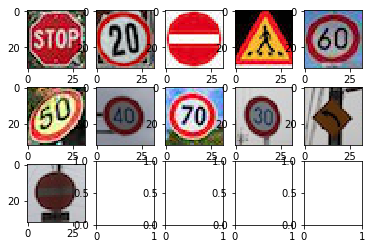

In [50]:
img_col=5
img_row=all_test_image.shape[0]//img_col+1
f,ax=plt.subplots(img_row,img_col)
for i in range(all_test_image.shape[0]):
    ax[i//img_col,i%img_col].imshow(all_test_image[i])

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
The traffic sign images are plotted above. The image qualities are no less than the training set. However, I deliberately added a very tilted traffic sign image (speed limit:50) to test the model.

In [51]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

In [52]:
all_conv_test_image=selected_pipeline.fit_transform(all_test_image.astype(np.uint8),None)

In [53]:
top_k=3 #the number of top probabilities to be output
predict=tf.argmax(logits, 1)
predict_prob=tf.nn.softmax(logits)
top_pred_prob=tf.nn.top_k(predict_prob,top_k)
with tf.Session() as sess:
    loader = tf.train.import_meta_graph(model_file_name+'.meta')
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    predictions=sess.run(predict_prob,feed_dict={x:all_conv_test_image,dropout_keep_prob:1.0})
    results=sess.run(top_pred_prob,feed_dict={x:all_conv_test_image,dropout_keep_prob:1.0})

### Images and predictions

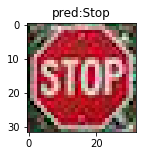

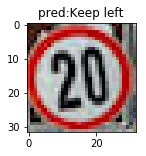

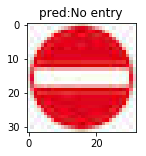

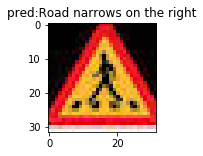

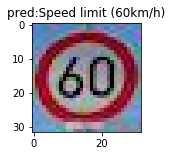

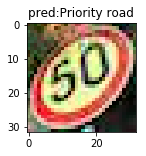

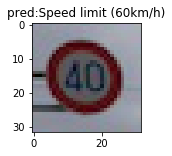

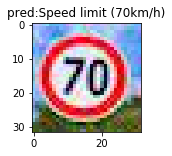

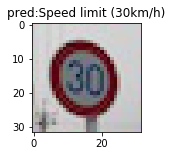

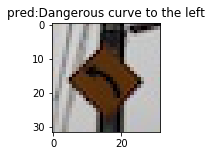

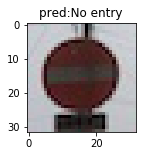

In [54]:
for i in range(all_test_image.shape[0]):
    plt.figure(figsize=(2,2))
    plt.imshow(all_test_image[i].astype(np.uint8))
    plt.title("pred:%s"%signnames_df.iloc[predictions[i].argmax(),0])

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

By examining the photos and the predicted result, the model predicts 6 out of 12 signs correctly, giving 50% accuracy. One of the traffic sign in these images, turning-left sign, does not belong to any class of the training data. Excluding this image gives 6/11=54.5% accuracy. However, the model recognized it as "Dangerous curve to the left", I would count it as the correct answer, given that this road sign is not in the training set. This gives 7/12=58.3% accuracy.
These values are however far below the accuracy tested on the test dataset (~97%). Since I use the accuracy of test data set to tune my model, this may overfit the model towards the test dataset.

In [55]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

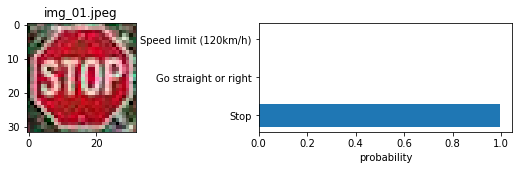

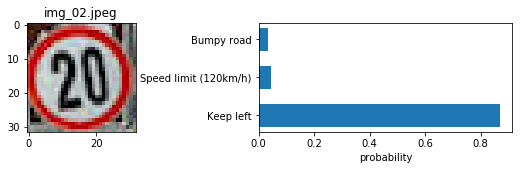

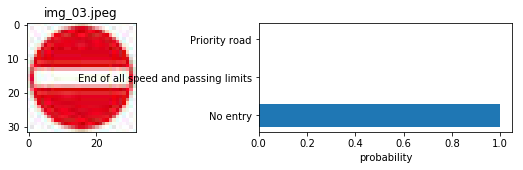

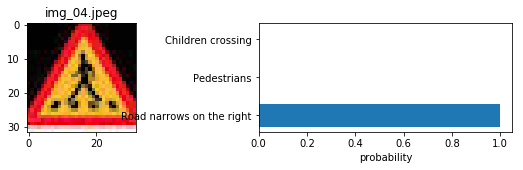

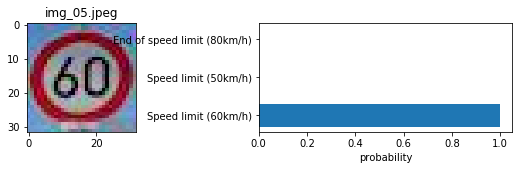

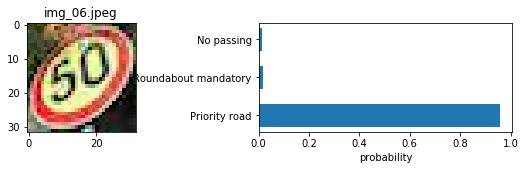

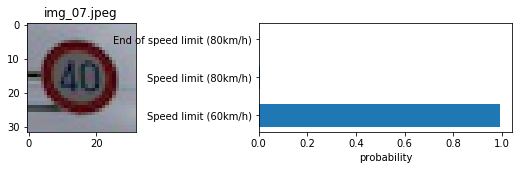

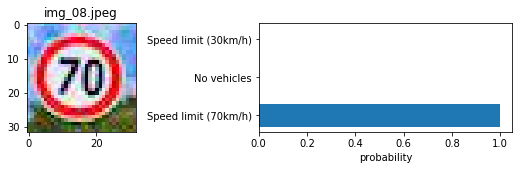

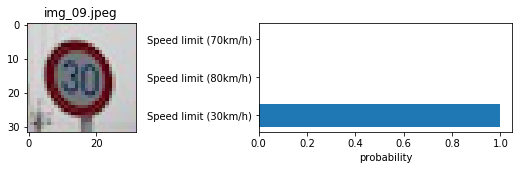

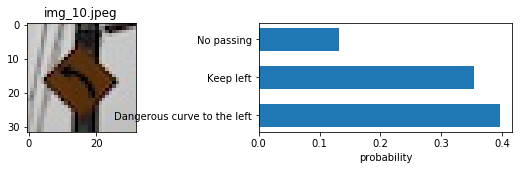

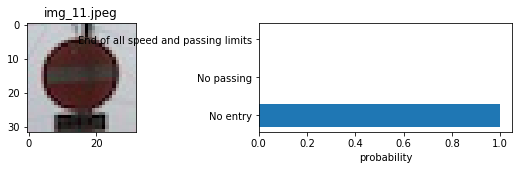

In [56]:
for i in range(results.values.shape[0]):
    fg,ax=plt.subplots(1,2,figsize=(10,2))
    idx=results.indices[i,:]
    width=2
    ind=np.arange(top_k)
    ax[0].imshow(all_test_image[i].astype(np.uint8))
    ax[0].set_title(image_filename[i])
    ax[1].barh(width+ind,
            results.values[i,:],width*0.3,align='center')
    ax[1].set_yticks(ind + width)
    ax[1].set_yticklabels(signnames_df.iloc[idx,0].values)
    ax[1].set_xlabel('probability')
    fg.savefig(os.path.join(add_image_dir,"prob_result_%s.png"%i))

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

The model gives all image very certain prediction (probability>0.8) except image_10. Among them, the predictions for image 2, 4, 6 and 7 are wrong and the correct answer did not show up in the top 3 candidates.
The model does not give image 10 very certain results. It is interesting to note that this image is not in one of the classes in training dta, but the model still recognizes that it is associated to "turning left".

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.